# Pix2Pix GAN
Following the Tensorflow tutorial. 
Steps:
1. Implement a conditional GAN pix2pix model. This architecture contains:
    - A generator with a U-Net based architecture
    - A discriminator represented by a convolutional PatchGAN classifier
    

In [1]:
import tensorflow as tf
import os
import pathlib
import time
import datetime

import matplotlib.pyplot as plt
from IPython import display

## Load Data

In [2]:
dataset_name = "facades"
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name


30168306/30168306 [==============================] - 14s 0us/step


In [3]:
list(PATH.parent.iterdir())

[WindowsPath('C:/Users/katie/.keras/datasets/facades'),
 WindowsPath('C:/Users/katie/.keras/datasets/facades.tar.gz'),
 WindowsPath('C:/Users/katie/.keras/datasets/flower_photos'),
 WindowsPath('C:/Users/katie/.keras/datasets/flower_photos.tar.gz')]

## EDA

In [4]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


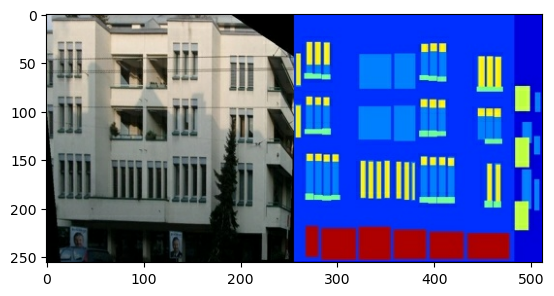

In [5]:
plt.figure()
plt.imshow(sample_image)

## Preprocess

We need to separate real building facade images from the architectural label images. Let's build a function that loads image files, and outputs two image tensors of size (256 x 256).

In [6]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Plot a sample of the input (architecutre label image) and real (building facade photo) images.

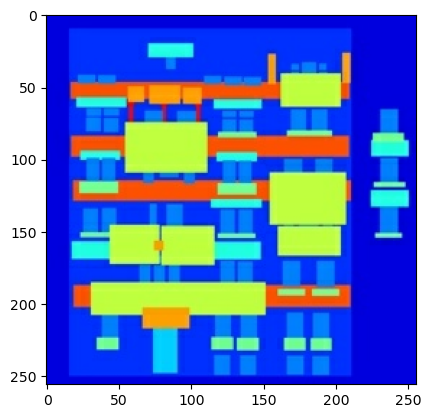

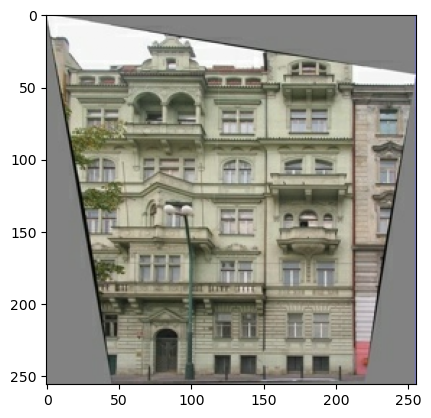

In [7]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

Let's apply jitter and mirroring.
Below are functions that:
1. Resize each 256 x 256 image to a larger height and width (286 x 286)
2. Randomly cropt it back to 256 x 256
3. Randomly flip the image horizontally (random mirroring)
4. Normalize the images to the [-1, 1] image.

In [8]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [10]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]


In [11]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [12]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

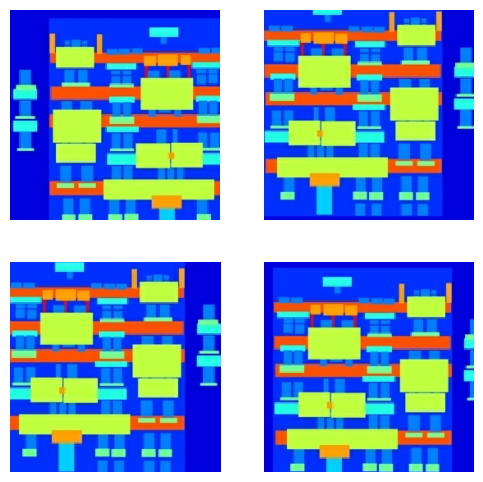

In [13]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

## Load the Preprocessed Training and Test Sets

In [14]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [15]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

### Build an Input Pipeline with tf.data

In [16]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [17]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build Generator

This is a modified U-Net. A U-net consists of an encoder (downsampler) and decoder (upsampler). 
- Each block in the encoder is: Convolution -> Batch Normalization -> Leaky ReLU
- Each block in the decoder is: Transposed Convolution -> Batch normalization -> Dropout (applied to first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (like the U-Net)

### Define the Encoder (Downsampler)

In [18]:
OUTPUT_CHANNELS = 3

In [19]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [20]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


### Define the Decoder (Upsampler)

In [21]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [22]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)


(1, 256, 256, 3)


### Define Generator

In [23]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
!pip install pydot graphviz

                                              0.0/47.0 kB ? eta -:--:--
     ---------------------------------      41.0/47.0 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 47.0/47.0 kB 782.9 kB/s eta 0:00:00


In [25]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


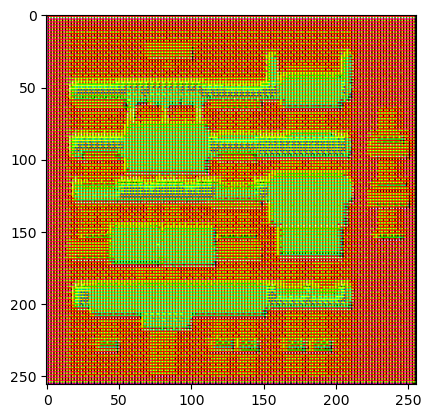

In [26]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Define Generator Loss
GANs learn a loss that adapts to the data. 
Conditional GANs learn a structured loss that penalizes a possible structure that is different from the network output, and the target image.
- The generator loss is a sigmoid cross-entropy loss of the generated images, and an array of ones.
- the pix2pix paper also mentions the L1 los, which is a MAE between the generated and target image.
- This allows the generated image to become structurally similar to the target image.
- The total generator loss is: `gan_loss + LAMBDA * l1_loss`


In [27]:
LAMBDA = 100

In [28]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [49]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # MAE
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + LAMBDA * l1_loss
    return total_gen_loss, gan_loss, l1_loss

## Build Discriminator

The discriminator is a convolutional PatchGAN classifier. It tries to classify if each image patch is real or not. 
- Each block in the discriminator is: Convolution -> Batch normalization -> Laeaky ReLU
- The shape of the output after the last layer is (batch_size, 30, 30, 1)
- Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image
- The discriminator receives 2 inputs:
    - The input image and the target image (classify should classify as real)
    - The input image and the generated image (the output of the generator), which should classify as fake
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together

In [50]:
def Discriminator():
    initializer = tf.random_normal_initializer(0,  0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name="input_image")
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name="target_image")
    
    x = tf.keras.layers.concatenate([inp, tar]) # (batch_size, 256, 256, channels)
    
    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, 
                                 kernel_initializer=initializer,
                                 use_bias=False)(zero_pad1)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    
    last = tf.keras.layers.Conv2D(1, 4, strides=1, 
                                 kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
    

In [51]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


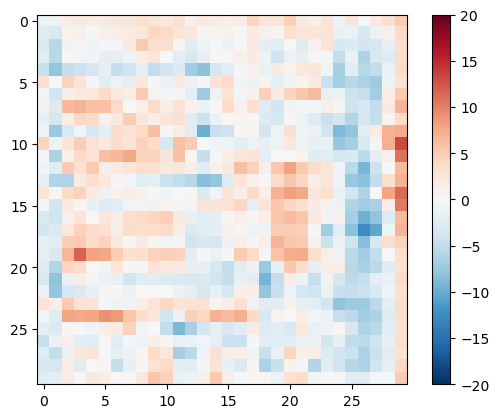

In [52]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Define the Discriminator Loss

- The `discriminator_loss` function takes 2 inputs: `real images` and `generated images`
- `real_loss` is a sigmoid cross-entropy loss of the `real images` and an array of ones (since they are real images).
- `generated_loss` is a sigmoid cross-entropy loss of the `generated images` and an array of zeros (since they are fake images).
- The `total_loss` is the sum of `real_loss` and `generated_loss`

In [37]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

### Define the Optimizers and a Checkpoint-Saver

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [39]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

## Generate Images

In [40]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicted Image"]
    
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    
    plt.show()

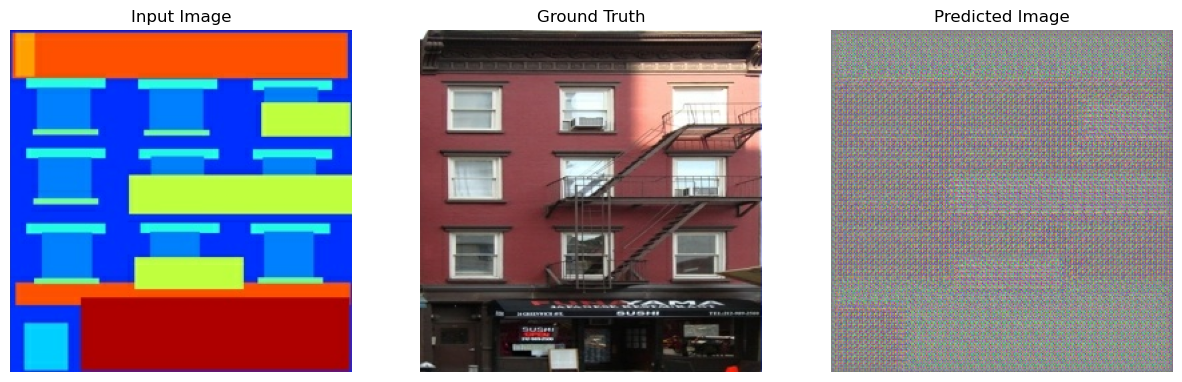

In [41]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

## Train

- Each example input, generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`. 
- Calculate the generator and discriminator loss
- Calculate the gradients of loss w.r.t. both the generator and the discriminator variables (inputs), and apply those to the optimizer.
- Lof the losses to Tensorboard.

In [42]:
log_dir = "logs/"
summary_writer = tf.summary.create_file_writer(
log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [58]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape(persistent=True) as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output,
                                                                  gen_output,
                                                                  target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                           generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                               discriminator.trainable_variables))

    del gen_tape
    del disc_tape
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step // 1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step // 1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step // 1000)
        tf.summary.scalar("disc_loss", disc_loss, step=step // 1000)

### The Actual Training Loop

This training loop is setup to work in steps instead of epochs. 

- Iterates over number of steps.
- Every 10 steps print a dot
- Every 1k steps: clear the display, run `generate_images` to show the progress
- Every 5k steps: save a checkpoint

In [47]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            
            if step != 0:
                print(f"Time taken for 1000 steps: {time.time() - start:0.2f} sec\n")

            start = time.time()
            
            generate_images(generator, example_input, example_target)
            print(f"Step: {step // 1000}k")
            
        train_step(input_image, target, step)
        
        # Training step
        if (step + 1) % 10 == 0:
            print(".", end='', flush=True)
        
        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [45]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

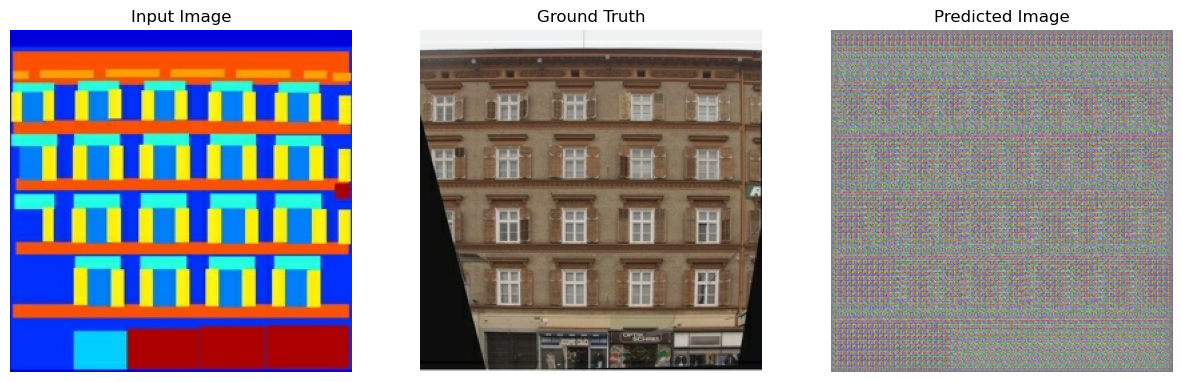

Step: 0k
................................

KeyboardInterrupt: 

In [59]:
fit(train_dataset, test_dataset, steps=40000)

## Evaluate

In [ ]:
tensorboard dev upload -- logdir {log_dir}

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px"
)